In [ ]:
from dask.array.image import imread as imr
import os
import napari
import numpy as np
import pandas as pd
import trackpy as tp
import matplotlib.pyplot as plt
import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack
import bigfish.plot as plot
from runBigfishDetection import saveSpotsNPZ, reorderZstack
from bigfish.detection.utils import get_object_radius_pixel
from buildReferenceSpot import buildReferenceSpotFromImages
from copy import deepcopy
pd.set_option('display.max_rows', 1500)
from runBigfishDetection import getSpotAndClusters, saveSpotsNPZ

In [178]:
homeFolder = '/media/rachel/9d56c1ff-e031-4e35-9f3c-fcd7d3e80033/Analysis/20230720/'
nameKey = 'Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_10ng.ml_tnf_exp1_4_F'
# homeFolder = '/home/rachel/single/spinningSequence/'
# nameKey = 'hela_K11_ON-_F'
imsQ = '11'
pathToTimeFrames = homeFolder+nameKey+imsQ+'/*.tif'
cellNumber = '1'
path_input = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/'
nucleiStackForm = nameKey+imsQ+"_cell_"
pathToTimeFramesCell = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/*.tif'
stackCell = imr(pathToTimeFramesCell)
MaxTimePoint = stackCell.shape[0]
path_input

'/media/rachel/9d56c1ff-e031-4e35-9f3c-fcd7d3e80033/Analysis/20230720/Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_10ng.ml_tnf_exp1_4_F11/cell_1/'

In [179]:
stackCell = imr(pathToTimeFramesCell)
print(stackCell.shape)
maxImageCell = np.max(stackCell, axis=1)

(900, 13, 189, 189)


In [180]:
pathTocellCrops = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/'


In [181]:
cellNumber = 1
spcl = np.load(pathTocellCrops+str(cellNumber)+'_spots_and_clusters.npz',allow_pickle=True)

spotsFrame = spcl['spotsFrame']
clustersFrames = spcl['clustersFrames']
ThresholdFrames = spcl['ThresholdFrames']
reference_spot = spcl['reference_spot']
refSpot = deepcopy(reference_spot)

1790.1000000000001


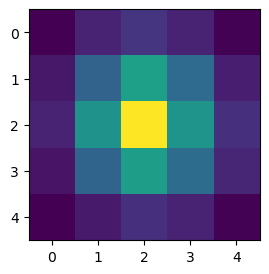

In [47]:
refSpot2D = np.max(reference_spot, axis=0)*0.45
plt.figure(num=3,figsize=(3,3))
plt.imshow(refSpot2D)
print(np.max(refSpot2D))

In [111]:
blurImage = []
for t in range(4,896):
    meanImage = np.mean([stackCell[t-4],
                         stackCell[t-3],
                         stackCell[t-2], 
                         stackCell[t-1], 
                         stackCell[t], 
                         stackCell[t+1], 
                         stackCell[t+2],
                         stackCell[t+3],
                         stackCell[t+4]], axis=0)
    blurImage.append(np.max(meanImage,axis=0))

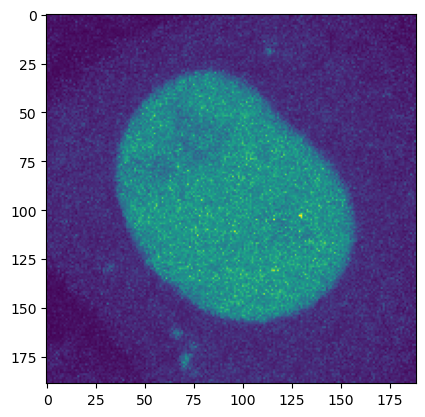

In [56]:
plt.imshow(np.max(stackCell[t-1], axis=0))

In [112]:
viewer = napari.Viewer()
image_layer = viewer.add_image(
        np.array(blurImage).astype(np.uint16), colormap='green' #maxImageCell
        )

In [113]:
bETA = 2.2
gAMMA = 5

voxelRadius2D = (121, 121)
objectRadius2D = (105, 105)
xPos = np.array([])
yPos = np.array([])
blurClusters = []


for t in range(0,len(blurImage)):

    rna = np.array(blurImage[t]).astype(np.uint16)

    # spot radius
    spot_radius_px = detection.get_object_radius_pixel(
        voxel_size_nm=voxelRadius2D,#(600, 80, 80), 
        object_radius_nm=objectRadius2D, 
        ndim=2)
pathToTimeFrames
    # LoG filter
    rna_log = stack.log_filter(rna, sigma=spot_radius_px)

    # local maximum detection
    mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)

    # thresholding
    threshold = detection.automated_threshold_setting(rna_log, mask)
#     print('Automatic Threshold (gradient) = '+str(threshold))
    spots_current, _ = detection.spots_thresholding(rna_log, mask,1700)
#     print('Automatic Threshold (difference) = '+str((kneedle.x[xx])))

#     plot.plot_detection(rna, 
#                             spots=[spots_current], 
#                             shape=["circle"], 
#                             radius=[3], 
#                             color=["red"],
#                             linewidth=[1], 
#                             fill=[False], 
#                             contrast=True)
        # gaussian kernel
    kernel_size = detection.get_object_radius_pixel(
        voxel_size_nm=voxelRadius2D, 
        object_radius_nm=objectRadius2D, 
        ndim=2)
    large_kernel_size = tuple([kernel_size_ * gAMMA for kernel_size_ in kernel_size])

    # denoising
    rna_denoised = stack.remove_background_gaussian(rna, sigma=large_kernel_size)

    # reference spot
    reference_spot = deepcopy(refSpot)

    # fit a gaussian function on the reference spot
    sigma_yx, amplitude, background = detection.modelize_spot(
        reference_spot=refSpot2D, 
        voxel_size=voxelRadius2D, 
        spot_radius=objectRadius2D)

    # detect dense regions
    regions_to_decompose, spots_out_regions, region_size = detection.get_dense_region_2(
        image=rna, 
        spots=spots_current,
        voxel_size=voxelRadius2D,
        spot_radius=objectRadius2D,
        reference_spot=refSpot2D,
        beta=bETA)

    print('time='+str(t))
    clusters = []
#     print(len(regions_to_decompose))
    ndim=2
    stack.check_array(
        rna,
        ndim=[2, 3],
        dtype=[np.uint8, np.uint16, np.float32, np.float64])
    # case where no region where detected
    if regions_to_decompose.size == 0:
        dense_regions = np.array([], dtype=rna.dtype).reshape((0, ndim + 4))
        blurClusters.append(np.array([],dtype=np.int64).reshape((0, 2)))
    #    return spots, dense_regions, reference_spot
    else :
        # precompute gaussian function values
        max_grid = max(200, region_size + 1)
        precomputed_gaussian = detection.precompute_erf(
            ndim=2,
            voxel_size=voxelRadius2D,
            sigma=(sigma_yx, sigma_yx),
            max_grid=max_grid)

        # simulate gaussian mixtures
        spots_in_regions, _ = detection.simulate_gaussian_mixture(
            image=rna,
            candidate_regions=regions_to_decompose,
            voxel_size=voxelRadius2D,
            sigma=(sigma_yx, sigma_yx),
            amplitude=amplitude,
            background=background,
            precomputed_gaussian=precomputed_gaussian)

        spots_post_decomposition = np.concatenate((spots_out_regions, spots_in_regions[:, :2]), axis=0)
    #         print("detected spots before decomposition")
    #         print("\r shape: {0}".format(spots_current.shape))
    #         print("\r dtype: {0}".format(spots_current.dtype), "\n")
    #         print("detected spots after decomposition")
    #         print("\r shape: {0}".format(spots_post_decomposition.shape))
    #         print("\r dtype: {0}".format(spots_post_decomposition.dtype))
#         plot.plot_detection(rna, 
#                                 spots=[spots_current, spots_in_regions[:, :2]], 
#                                 shape=["circle", "polygon"], 
#                                 radius=[3, 6], 
#                                 color=["red", "yellow"],
#                                 linewidth=[1, 2], 
#                                 fill=[False, False], 
#                                 contrast=True)
        
        spots_post_clustering, clusters = detection.detect_clusters(
            spots=spots_post_decomposition, 
            voxel_size=voxelRadius2D, 
            radius=400, 
            nb_min_spots=5)
#         print(clusters)
        xPos = np.hstack([xPos,clusters[:,0]])
        yPos = np.hstack([yPos,clusters[:,1]])

        blurClusters.append(clusters[:,0:2])

#         print("detected spots after clustering")
#         print("\r shape: {0}".format(spots_post_clustering.shape))
#         print("\r dtype: {0}".format(spots_post_clustering.dtype), "\n")
#         print("detected clusters")
#         print("\r shape: {0}".format(clusters.shape))
#         print("\r dtype: {0}".format(clusters.dtype))
#         plot.plot_detection(rna, 
#                             spots=[spots_current, clusters[:,:2]], 
#                             shape=["circle", "polygon"], 
#                             radius=[3, 6], 
#                             color=["red", "blue"],
#                             linewidth=[1, 2], 
#                             fill=[False, False], 
#                             contrast=True)


time=0
time=1
time=2
time=3
time=4
time=5
time=6
time=7
time=8
time=9
time=10
time=11
time=12
time=13
time=14
time=15
time=16
time=17
time=18
time=19
time=20
time=21
time=22
time=23


/home/rachel/anaconda3/envs/napari_env/lib/python3.9/site-packages/bigfish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


time=24
time=25
time=26
time=27
time=28
time=29
time=30
time=31
time=32
time=33
time=34
time=35
time=36
time=37
time=38
time=39
time=40
time=41
time=42
time=43
time=44
time=45
time=46
time=47
time=48
time=49
time=50
time=51
time=52
time=53
time=54
time=55
time=56
time=57
time=58
time=59
time=60
time=61
time=62
time=63
time=64
time=65
time=66
time=67
time=68
time=69
time=70
time=71
time=72
time=73
time=74
time=75
time=76
time=77
time=78
time=79
time=80
time=81
time=82
time=83
time=84
time=85
time=86
time=87
time=88
time=89
time=90
time=91
time=92
time=93
time=94
time=95
time=96
time=97
time=98
time=99
time=100
time=101
time=102
time=103
time=104
time=105
time=106
time=107
time=108
time=109
time=110
time=111
time=112
time=113
time=114
time=115
time=116
time=117
time=118
time=119
time=120
time=121
time=122
time=123
time=124
time=125
time=126
time=127
time=128
time=129
time=130
time=131
time=132
time=133
time=134
time=135
time=136
time=137
time=138
time=139
time=140
time=141
time=142
time=

/home/rachel/anaconda3/envs/napari_env/lib/python3.9/site-packages/bigfish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


time=205
time=206
time=207
time=208
time=209
time=210
time=211
time=212
time=213
time=214
time=215
time=216
time=217
time=218
time=219
time=220
time=221
time=222
time=223
time=224
time=225
time=226
time=227
time=228
time=229
time=230
time=231
time=232
time=233
time=234
time=235
time=236
time=237
time=238
time=239
time=240
time=241
time=242
time=243
time=244
time=245
time=246
time=247
time=248
time=249
time=250
time=251
time=252
time=253
time=254
time=255
time=256
time=257
time=258
time=259
time=260
time=261
time=262
time=263
time=264
time=265
time=266
time=267
time=268
time=269
time=270
time=271
time=272
time=273
time=274
time=275
time=276
time=277
time=278
time=279
time=280
time=281
time=282
time=283
time=284
time=285
time=286
time=287
time=288
time=289
time=290
time=291
time=292
time=293
time=294
time=295
time=296
time=297
time=298
time=299
time=300
time=301
time=302
time=303
time=304
time=305
time=306
time=307
time=308
time=309
time=310
time=311
time=312
time=313
time=314
time=315
t

/home/rachel/anaconda3/envs/napari_env/lib/python3.9/site-packages/bigfish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


time=510
time=511
time=512
time=513
time=514
time=515
time=516
time=517
time=518
time=519
time=520
time=521
time=522
time=523
time=524
time=525
time=526
time=527
time=528
time=529
time=530
time=531
time=532
time=533
time=534
time=535
time=536
time=537
time=538
time=539
time=540
time=541
time=542
time=543
time=544
time=545
time=546
time=547
time=548
time=549
time=550
time=551
time=552
time=553
time=554
time=555
time=556
time=557
time=558
time=559
time=560
time=561
time=562
time=563
time=564
time=565
time=566


/home/rachel/anaconda3/envs/napari_env/lib/python3.9/site-packages/bigfish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


time=567
time=568
time=569
time=570
time=571
time=572
time=573
time=574
time=575
time=576
time=577
time=578
time=579
time=580
time=581
time=582
time=583
time=584
time=585
time=586
time=587
time=588
time=589
time=590
time=591
time=592
time=593
time=594
time=595
time=596
time=597
time=598
time=599
time=600
time=601
time=602
time=603
time=604
time=605
time=606
time=607
time=608
time=609
time=610
time=611
time=612
time=613
time=614
time=615
time=616
time=617
time=618
time=619
time=620
time=621
time=622
time=623
time=624
time=625
time=626
time=627
time=628
time=629
time=630
time=631
time=632
time=633
time=634
time=635
time=636
time=637
time=638
time=639
time=640
time=641
time=642
time=643
time=644
time=645
time=646
time=647
time=648
time=649
time=650
time=651
time=652
time=653
time=654
time=655
time=656
time=657
time=658
time=659
time=660
time=661
time=662
time=663
time=664
time=665
time=666
time=667
time=668
time=669
time=670
time=671
time=672
time=673
time=674
time=675
time=676
time=677
t

In [114]:


def getDetectedClustersForFrameBlur(pts_coordinates, frameNumer):
    sd = np.shape(pts_coordinates[frameNumer][:])
    pts_coords = np.empty([sd[0],sd[1]])
    for ii in range(np.shape(pts_coordinates[frameNumer][:])[0]):
        pts_coords[ii,:] = pts_coordinates[frameNumer][ii][:]
    return pts_coords

def set_pts_features(cls_layer, cluster_coordinate, step): #TxLayer
    # step is a 4D coordinate with the current slider position for each dim
    frameNumber = step[0]  # grab the leading ("time") coordinate
    cls_layer.data = getDetectedClustersForFrameBlur(cluster_coordinate,frameNumber)


cluster_coordinate_blur = blurClusters
viewer = napari.Viewer()
image_layer = viewer.add_image(
        np.array(blurImage).astype(np.uint16), colormap='green' #maxImageCell
        )

bigfish_clusters_blur = viewer.add_points(
        getDetectedClustersForFrameBlur(cluster_coordinate_blur,int(np.shape(blurImage)[0]/2)),
        face_color='#00000000',
        size=8,
        edge_width=0.3,
        edge_width_is_relative=False,
        edge_color='red',
        face_color_cycle = ['red'],
        symbol='diamond',
        name = 'bigFish Clusters'
        )

viewer.dims.events.current_step.connect(
        lambda event: set_pts_features(bigfish_clusters_blur, cluster_coordinate_blur, event.value)
        )


<function __main__.<lambda>(event)>

In [115]:
MaxTimePoint = len(blurImage)
clustersFrames = cluster_coordinate_blur
features = pd.DataFrame(clustersFrames[0][:,0:],columns=['y','x'])
features['frame']=1
for ll in range(1,MaxTimePoint):
    new_row = pd.DataFrame(clustersFrames[ll][:,0:],columns=['y','x'])
    new_row['frame']=ll+1
    features = pd.concat([features,new_row], ignore_index=True)
features

,y,x,frame
0,119,134,73
1,119,134,74
2,119,134,75
3,119,134,76
4,119,134,77
5,120,134,78
6,120,134,79
7,120,134,80
8,120,134,81
9,120,134,82


In [116]:
linkedTrajectories = tp.link(features, 8, memory=200) #15 first
linkedTrajectories

Frame 892: 3 trajectories present.


,y,x,frame,particle
0,119,134,73,0
1,119,134,74,0
2,119,134,75,0
3,119,134,76,0
4,119,134,77,0
5,120,134,78,0
6,120,134,79,0
7,120,134,80,0
8,120,134,81,0
9,120,134,82,0


In [117]:
linkedTrajectories['track_length']=0
trajectoryLengths = linkedTrajectories['particle'].value_counts()
i=0
for jj in trajectoryLengths.index:
    linkedTrajectories.loc[linkedTrajectories['particle']==jj,'track_length']=trajectoryLengths.values[i]
    i+=1
linkedTrajectories

,y,x,frame,particle,track_length
0,119,134,73,0,306
1,119,134,74,0,306
2,119,134,75,0,306
3,119,134,76,0,306
4,119,134,77,0,306
5,120,134,78,0,306
6,120,134,79,0,306
7,120,134,80,0,306
8,120,134,81,0,306
9,120,134,82,0,306


In [118]:
dft = pd.concat([linkedTrajectories.iloc[:,3:4], # particle
                    linkedTrajectories.iloc[:,2:3]-1, # frame
                    linkedTrajectories.iloc[:,0:2]], axis=1) # coord
dft.columns = ['track_id','t','y','x']

In [119]:
dd=dft.sort_values(by=['track_id', 't'])
tracks_data = np.asarray(dd)

In [136]:
def getDetectedClustersForFrameBlur(pts_coordinates, frameNumer):
    sd = np.shape(pts_coordinates[frameNumer][:])
    pts_coords = np.empty([sd[0],sd[1]])
    for ii in range(np.shape(pts_coordinates[frameNumer][:])[0]):
        pts_coords[ii,:] = pts_coordinates[frameNumer][ii][:]
    return pts_coords

def set_pts_features(tracks_layers, cls_layer, cluster_coordinate, step):
    # step is a 4D coordinate with the current slider position for each dim
    frameNumber = step[0]  # grab the leading ("time") coordinate
#     pts_layer.data = getDetectedPointsForFrame(pts_coordinates,frameNumber)
    cls_layer.data = getDetectedClustersForFrameBlur(cluster_coordinate,frameNumber)
# pts_coordinates = spotsFrame
# cluster_coordinate = deepcopy(newClusterCoordinate)
cluster_coordinate_blur = blurClusters
viewer = napari.Viewer()
image_layer = viewer.add_image(
        np.array(blurImage).astype(np.uint16), colormap='green' #maxImageCell
        )

bigfish_clusters_blur = viewer.add_points(
        getDetectedClustersForFrameBlur(cluster_coordinate_blur,int(np.shape(blurImage)[0]/2)),
        face_color='#00000000',
        size=8,
        edge_width=0.3,
        edge_width_is_relative=False,
        edge_color='red',
        face_color_cycle = ['red'],
        symbol='diamond',
        name = 'bigFish Clusters'
        )


bigfish_tracks = viewer.add_tracks(tracks_data, 
                                   name='TS tracks')

viewer.dims.events.current_step.connect(
        lambda event: set_pts_features(bigfish_tracks, bigfish_clusters_blur, cluster_coordinate_blur, event.value)
        )

<function __main__.<lambda>(event)>

In [144]:
idx = np.where(linkedTrajectories['particle']==1)[0]

In [150]:
idx = np.where(linkedTrajectories['particle']==3)[0]

In [151]:
linkedTrajectories.iloc[idx,3]=4

In [152]:
dft = pd.concat([linkedTrajectories.iloc[:,3:4], # particle
                    linkedTrajectories.iloc[:,2:3]-1, # frame
                    linkedTrajectories.iloc[:,0:2]], axis=1) # coord
dft.columns = ['track_id','t','y','x']
dd=dft.sort_values(by=['track_id', 't'])
tracks_data = np.asarray(dd)

In [182]:
def getDetectedClustersForFrameBlur(pts_coordinates, frameNumer):
    sd = np.shape(pts_coordinates[frameNumer][:])
    pts_coords = np.empty([sd[0],sd[1]])
    for ii in range(np.shape(pts_coordinates[frameNumer][:])[0]):
        pts_coords[ii,:] = pts_coordinates[frameNumer][ii][:]
    return pts_coords

def set_pts_features(tracks_layers, cls_layer, cluster_coordinate, step):
    # step is a 4D coordinate with the current slider position for each dim
    frameNumber = step[0]  # grab the leading ("time") coordinate
#     pts_layer.data = getDetectedPointsForFrame(pts_coordinates,frameNumber)
    cls_layer.data = getDetectedClustersForFrameBlur(cluster_coordinate,frameNumber)
# pts_coordinates = spotsFrame
# cluster_coordinate = deepcopy(newClusterCoordinate)
cluster_coordinate_blur = blurClusters
viewer = napari.Viewer()
image_layer = viewer.add_image(
        np.array(blurImage).astype(np.uint16), colormap='green' #maxImageCell
        )

bigfish_clusters_blur = viewer.add_points(
        getDetectedClustersForFrameBlur(cluster_coordinate_blur,int(np.shape(blurImage)[0]/2)),
        face_color='#00000000',
        size=8,
        edge_width=0.3,
        edge_width_is_relative=False,
        edge_color='red',
        face_color_cycle = ['red'],
        symbol='diamond',
        name = 'bigFish Clusters'
        )


bigfish_tracks = viewer.add_tracks(tracks_data, 
                                   name='TS tracks')

viewer.dims.events.current_step.connect(
        lambda event: set_pts_features(bigfish_tracks, bigfish_clusters_blur, cluster_coordinate_blur, event.value)
        )

<function __main__.<lambda>(event)>

Traceback (most recent call last):
  File "/home/rachel/anaconda3/envs/napari_env/lib/python3.9/site-packages/napari/_qt/layer_controls/qt_points_controls.py", line 272, in changeCurrentSize
    self.layer.current_size = value
  File "/home/rachel/anaconda3/envs/napari_env/lib/python3.9/site-packages/napari/layers/points/points.py", line 869, in current_size
    self.size[idx] = size
IndexError: index 1 is out of bounds for axis 0 with size 0
Traceback (most recent call last):
  File "/home/rachel/anaconda3/envs/napari_env/lib/python3.9/site-packages/napari/_qt/layer_controls/qt_points_controls.py", line 272, in changeCurrentSize
    self.layer.current_size = value
  File "/home/rachel/anaconda3/envs/napari_env/lib/python3.9/site-packages/napari/layers/points/points.py", line 869, in current_size
    self.size[idx] = size
IndexError: index 1 is out of bounds for axis 0 with size 0
Traceback (most recent call last):
  File "/home/rachel/anaconda3/envs/napari_env/lib/python3.9/site-packa

Traceback (most recent call last):
  File "/home/rachel/anaconda3/envs/napari_env/lib/python3.9/site-packages/napari/_qt/layer_controls/qt_points_controls.py", line 272, in changeCurrentSize
    self.layer.current_size = value
  File "/home/rachel/anaconda3/envs/napari_env/lib/python3.9/site-packages/napari/layers/points/points.py", line 869, in current_size
    self.size[idx] = size
IndexError: index 0 is out of bounds for axis 0 with size 0
Traceback (most recent call last):
  File "/home/rachel/anaconda3/envs/napari_env/lib/python3.9/site-packages/napari/_qt/layer_controls/qt_points_controls.py", line 272, in changeCurrentSize
    self.layer.current_size = value
  File "/home/rachel/anaconda3/envs/napari_env/lib/python3.9/site-packages/napari/layers/points/points.py", line 869, in current_size
    self.size[idx] = size
IndexError: index 0 is out of bounds for axis 0 with size 0
Traceback (most recent call last):
  File "/home/rachel/anaconda3/envs/napari_env/lib/python3.9/site-packa

In [154]:
linkedTrajectories

,y,x,frame,particle,track_length
0,119,134,73,0,306
1,119,134,74,0,306
2,119,134,75,0,306
3,119,134,76,0,306
4,119,134,77,0,306
5,120,134,78,0,306
6,120,134,79,0,306
7,120,134,80,0,306
8,120,134,81,0,306
9,120,134,82,0,306


In [162]:
moviePath = homeFolder+nameKey+imsQ

'/media/rachel/9d56c1ff-e031-4e35-9f3c-fcd7d3e80033/Analysis/20230720/Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_10ng.ml_tnf_exp1_4_F11'

In [158]:
particle_1 = linkedTrajectories[linkedTrajectories['particle']==0]
particle_2 = linkedTrajectories[linkedTrajectories['particle']==4]

In [170]:
particle_2.to_pickle(moviePath+'/cellNumber_'+str(cellNumber)+'_particle_2.pkl')